# This notebook generates the following figures in our main paper

### Figure 4 Final Predictions for all cases

## note: you need to generate dataset before running this notebook

## environment 

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # fetch GPU list
os.environ["CUDA_VISIBLE_DEVICES"]="1" # assign GPU 
import time
import torch
torch.set_num_threads(1) 
torch.set_default_dtype(torch.float64)
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import matplotlib
import matplotlib.pyplot
import matplotlib.pyplot as plt
%matplotlib inline
import math
import torch.optim as optim
from tqdm import tqdm
from torch.nn.parameter import Parameter
import sys
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print device
from collections import OrderedDict
import seaborn as sns
import pandas as pd
import itertools

cuda:0


In [2]:
path = os.getcwd() 
parent_path = os.path.abspath(os.path.join(path, os.pardir))
sys.path.append(parent_path)

## Euler method for benchmark 

In [3]:
def eulerPrediction(data,T,data_option,forcingterm=None):
    
    tLen = data.shape[1]
    xLen = data.shape[2]
    sampleNo = data.shape[0]
    
    x = data.data.transpose(1,2)
    
    beta = 0.0002
    dx = 0.1
    dt = 1000.0/(tLen-1)+0.0
    alpha = beta*dt/dx**2+0.0 # alpha value

    predListEU   = torch.zeros((sampleNo,xLen,tLen)).to(device)
    for j in range(tLen-1): 
        for k in range(1,xLen-1,1):
            predListEU[:,k,j+1] = x[:,k,j] + alpha*(x[:,k-1,j] - 2*x[:,k,j] + x[:,k+1,j]) 
            if data_option == 3:
                predListEU[:,k,j+1] = predListEU[:,k,j+1] + beta*dt*forcingterm[:,k,j+1]
            x[:,k,j+1] = predListEU[:,k,j+1] 
            
    x = x.data.transpose(1,2)
    EUpred = []
    for t in T:
        EUpred.append(x[:,t:t+1,:].data.cpu().numpy())
        
    return EUpred

## please generate data and place the paths here 

In [5]:
stabledata = '/home/takacMLGroup/DNN_FOR_PDEs/newData/data/case0_dt1.00e+00.tar'
unstabledata = '/home/takacMLGroup/DNN_FOR_PDEs/newData/data/case1_dt2.00e+02.tar'
midnoisedata = '/home/takacMLGroup/DNN_FOR_PDEs/newData/data/case2_err1.00e-04_dt1.00e+00.tar'
forcedata = '/home/takacMLGroup/DNN_FOR_PDEs/newData/data/case3_force1.00e+01_dt1.00e+00.tar'

## load stable data and pretrained model

In [7]:
# remain the same across the board
from DataGenerator.DataGene import *
n = 10
x_max = np.pi
x_min = 0.0
num_x = 30
T_max = 1000.0
beta = 5000.0
IC = 200
generator = DataGene(device=device,n=n,x_max=x_max,x_min=x_min,num_x=num_x,T_max=T_max,beta=beta,IC=IC)


data_option = 0 # other cases need to change this
T_data = [200,400,600,800,1000]
T_plot = [200,400,600,800,1000]
dt = 1.0 
length = int(T_max/dt) # this is the time horizon

# place your data file location here
datafile = stabledata
wholedata = torch.load(datafile)

dataset = wholedata['data']
traindata = wholedata['train']
testdata = wholedata['test']

# normalize by adding 1.0
testdata[:,30,:]=0.0
testdata = testdata+1.0

x, _ = generator.DataForTest(testdata,length) 

testdata = torch.tensor(testdata-1.0,dtype=torch.float64,device=device).transpose(1,2)
stable_real_signal = [testdata[:,0:1,:].data+0.0] # list of tensor

for t in T_data:
    stable_real_signal.append(testdata[:,t:t+1,:].data+0.0)
    
stable_folder = parent_path+'/Pretrained/stable/'
    
TRdire = stable_folder+'TR/'
ADdire = stable_folder+'Adam/'
TRfile = TRdire+'file.tar'
ADfile = ADdire+'file.tar'
TRfilelist = torch.load(TRfile)['best']
ADfilelist = torch.load(ADfile)['best']
FR = [2,4,8,16]
FB = [1,2,3,4]

TRbest = []
A3best = []
A4best = []


TRend = []
A3end = []
A4end = []

for f in TRfilelist:
    TRbest.append(f)
        
for f in torch.load(TRfile)['result']:
    TRend.append(f)
    
for f in ADfilelist:
    if 'LR0.001_' in f:
        A3best.append(f)
    if 'LR0.0001' in f:
        A4best.append(f)

for f in torch.load(ADfile)['result']:    
    if 'LR0.001_' in f:
        A3end.append(f)
    if 'LR0.0001' in f:
        A4end.append(f)
        
TR_err_best = np.inf
A3_err_best = np.inf
A4_err_best = np.inf

TR_best_parm = []
A3_best_parm = []
A4_best_parm = []

for f in TRbest:
    f = stable_folder+'TR/'+f
    if os.path.exists(f)==False:
        print 'Not Found %s'%f
        continue
    temp = torch.load(f)
    if temp['sqMSE'][-1] < TR_err_best:
        TR_err_best = temp['sqMSE'][-1]
        best_f = f
    
TR_best_parm = [f,torch.load(best_f)['parm'],torch.load(best_f)['sqMSE'][-1],torch.load(best_f)['weight']]


for f in A3best:
    f = stable_folder+'Adam/'+f
    if os.path.exists(f)==False:
#         print 'Not Found %s'%f
        continue
    temp = torch.load(f)
    if temp['sqMSE'][-1] < A3_err_best:
        A3_err_best = temp['sqMSE'][-1]
        best_f = f
    
A3_best_parm = [f,torch.load(best_f)['parm'],torch.load(best_f)['sqMSE'][-1],torch.load(best_f)['weight']]




for f in A4best:
    f = stable_folder+'Adam/'+f
    if os.path.exists(f)==False:
#         print 'Not Found %s'%f
        continue
    temp = torch.load(f)
    if temp['sqMSE'][-1] < A4_err_best:
        A4_err_best = temp['sqMSE'][-1]
        best_f = f
    
A4_best_parm = [f,torch.load(best_f)['parm'],torch.load(best_f)['sqMSE'][-1],torch.load(best_f)['weight']]

from Models.FDNET import fdnet
xLen = 31


seed = TR_best_parm[1][0]
bs = TR_best_parm[1][1]
fdfilters = TR_best_parm[1][2]
fdblocks = TR_best_parm[1][3]
w0 = TR_best_parm[3]

print 'best run for TR: seed-%s, FD-Filters-%s, FD-Block-%s' %(seed,fdfilters,fdblocks)

DNN = 'fdnet'
model = getattr(sys.modules[__name__], DNN)(1,fdfilters,xLen).to(device)
for w,m in zip(w0,model.parameters()):
    m.data.set_(torch.tensor(w,dtype=torch.float64).to(device))

TR_pred_parm = [seed,bs,fdfilters,fdblocks]

# data used to plot
stable_TR_pred = []

y_pred_temp = x.data+0.0
with torch.no_grad():
    for t in xrange(length):
        y_pred_temp = model(y_pred_temp,fdblocks)
        if t+1 in T_data: # t+1 would be original t, ex: t=199 would be the 200th iteration and hence t=200
            y_pred = y_pred_temp.data-1.0
            stable_TR_pred.append(y_pred.data.cpu().numpy())
            
print 'TR: recorded 1000 steps MSE minimum: %.8e'%TR_best_parm[2]
print 'Calculated MSE minimum:          %.8e'%(np.sum((stable_TR_pred[4] - stable_real_signal[5].cpu().numpy())**2)/50.0/31.0)


seed = A3_best_parm[1][0]
bs = A3_best_parm[1][1]
fdfilters = A3_best_parm[1][2]
fdblocks = A3_best_parm[1][3]
lr = A3_best_parm[1][4]
w0 = A3_best_parm[3]

print 'best run for A-1e-03: seed-%s, FD-Filters-%s, FD-Blocks-%s, learningrate-%.2e' \
        %(seed,fdfilters,fdblocks,lr)

DNN = 'fdnet'
model = getattr(sys.modules[__name__], DNN)(1,fdfilters,xLen).to(device)
for w,m in zip(w0,model.parameters()):
    m.data.set_(torch.tensor(w,dtype=torch.float64).to(device))

A3_pred_parm = [seed,bs,fdfilters,fdblocks,lr]


# data used to plot
stable_A3_pred = []


y_pred_temp = x.data+0.0
with torch.no_grad():
    for t in xrange(length):
        y_pred_temp = model(y_pred_temp,fdblocks)
        if t+1 in T_data: # t+1 would be original t, ex: t=199 would be the 200th iteration and hence t=200
            y_pred = y_pred_temp.data-1.0
            stable_A3_pred.append(y_pred.data.cpu().numpy())
            
print 'A1e-03: recorded 1000 steps MSE minimum: %.8e'%A3_best_parm[2]
print 'Calculated MSE minimum:          %.8e'%(np.sum((stable_A3_pred[4] - stable_real_signal[5].cpu().numpy())**2)/50.0/31.0)

seed = A4_best_parm[1][0]
bs = A4_best_parm[1][1]
fdfilters = A4_best_parm[1][2]
fdblocks = A4_best_parm[1][3]
lr = A4_best_parm[1][4]
w0 = A4_best_parm[3]

print 'best run for A-1e-04: seed-%s, FD-Filters-%s, FD-Blocks-%s, learningrate-%.2e' \
        %(seed,fdfilters,fdblocks,lr)

DNN = 'fdnet'
model = getattr(sys.modules[__name__], DNN)(1,fdfilters,xLen).to(device)
for w,m in zip(w0,model.parameters()):
    m.data.set_(torch.tensor(w,dtype=torch.float64).to(device))

A4_pred_parm = [seed,bs,fdfilters,fdblocks,lr]


# data used to plot
stable_A4_pred = []


y_pred_temp = x.data+0.0
with torch.no_grad():
    for t in xrange(length):
        y_pred_temp = model(y_pred_temp,fdblocks)
        if t+1 in T_data: # t+1 would be original t, ex: t=199 would be the 200th iteration and hence t=200
            y_pred = y_pred_temp.data-1.0
            stable_A4_pred.append(y_pred.data.cpu().numpy())
            
print 'A1e-04: recorded 1000 steps MSE minimum: %.8e'%A4_best_parm[2]
print 'Calculated MSE minimum:          %.8e'%(np.sum((stable_A4_pred[4] - stable_real_signal[5].cpu().numpy())**2)/50.0/31.0)


if data_option == 3:
    stable_EU_pred = eulerPrediction(testdata,T_data,data_option,forcingterm)
else:
    stable_EU_pred = eulerPrediction(testdata,T_data,data_option)
    
print 'Euler: Calculated 1000 step minimum MSE: %.8e'%(np.sum((stable_EU_pred[4]-stable_real_signal[5].cpu().numpy())**2)/50.0/31.0)

best run for TR: seed-2, FD-Filters-16, FD-Block-1
TR: recorded 1000 steps MSE minimum: 3.17748025e-09
Calculated MSE minimum:          3.17748025e-09
best run for A-1e-03: seed-9, FD-Filters-16, FD-Blocks-1, learningrate-1.00e-03
A1e-03: recorded 1000 steps MSE minimum: 4.12830639e-06
Calculated MSE minimum:          4.12830639e-06
best run for A-1e-04: seed-9, FD-Filters-16, FD-Blocks-1, learningrate-1.00e-04
A1e-04: recorded 1000 steps MSE minimum: 3.33157775e-05
Calculated MSE minimum:          3.33157775e-05
Euler: Calculated 1000 step minimum MSE: 1.18853738e-05


## load unstable data and pretrained model 

In [8]:
# remain the same across the board
from DataGenerator.DataGene import *
n = 10
x_max = np.pi
x_min = 0.0
num_x = 30
T_max = 1000.0
beta = 5000.0
IC = 200
generator = DataGene(device=device,n=n,x_max=x_max,x_min=x_min,num_x=num_x,T_max=T_max,beta=beta,IC=IC)


data_option = 1 # other cases need to change this
T_data = [1,2,3,4,5]
T_plot = [200,400,600,800,1000]
dt = 200.0
length = int(T_max/dt) # this is the time horizon

# place your data file location here
datafile = unstabledata
wholedata = torch.load(datafile)

dataset = wholedata['data']
traindata = wholedata['train']
testdata = wholedata['test']

dt_list = [i for i in xrange(0,int(T_max+dt),int(dt))]
testdata = testdata[:,:,dt_list]

# normalize by adding 1.0
testdata[:,30,:]=0.0
testdata = testdata+1.0

x, _ = generator.DataForTest(testdata,length) 

testdata = torch.tensor(testdata-1.0,dtype=torch.float64,device=device).transpose(1,2)
unstable_real_signal = [testdata[:,0:1,:].data+0.0] # list of tensor

for t in T_data:
    unstable_real_signal.append(testdata[:,t:t+1,:].data+0.0)
    
unstable_folder = parent_path+'/Pretrained/unstable/'
    
TRdire = unstable_folder+'TR/'
ADdire = unstable_folder+'Adam/'
TRfile = TRdire+'file.tar'
ADfile = ADdire+'file.tar'
TRfilelist = torch.load(TRfile)['best']
ADfilelist = torch.load(ADfile)['best']
FR = [2,4,8,16]
FB = [1,2,3,4,6,8,10]

TRbest = []
A3best = []
A4best = []


TRend = []
A3end = []
A4end = []

for f in TRfilelist:
    TRbest.append(f)
        
for f in torch.load(TRfile)['result']:
    TRend.append(f)
    
for f in ADfilelist:
    if 'LR0.001_' in f:
        A3best.append(f)
    if 'LR0.0001' in f:
        A4best.append(f)

for f in torch.load(ADfile)['result']:    
    if 'LR0.001_' in f:
        A3end.append(f)
    if 'LR0.0001' in f:
        A4end.append(f)
        
TR_err_best = np.inf
A3_err_best = np.inf
A4_err_best = np.inf

TR_best_parm = []
A3_best_parm = []
A4_best_parm = []

for f in TRbest:
    f = unstable_folder+'TR/'+f
    if os.path.exists(f)==False:
        print 'Not Found %s'%f
        continue
    temp = torch.load(f)
    if temp['sqMSE'][-1] < TR_err_best:
        TR_err_best = temp['sqMSE'][-1]
        best_f = f
    
TR_best_parm = [f,torch.load(best_f)['parm'],torch.load(best_f)['sqMSE'][-1],torch.load(best_f)['weight']]


for f in A3best:
    f = unstable_folder+'Adam/'+f
    if os.path.exists(f)==False:
#         print 'Not Found %s'%f
        continue
    temp = torch.load(f)
    if temp['sqMSE'][-1] < A3_err_best:
        A3_err_best = temp['sqMSE'][-1]
        best_f = f
    
A3_best_parm = [f,torch.load(best_f)['parm'],torch.load(best_f)['sqMSE'][-1],torch.load(best_f)['weight']]




for f in A4best:
    f = unstable_folder+'Adam/'+f
    if os.path.exists(f)==False:
#         print 'Not Found %s'%f
        continue
    temp = torch.load(f)
    if temp['sqMSE'][-1] < A4_err_best:
        A4_err_best = temp['sqMSE'][-1]
        best_f = f
    
A4_best_parm = [f,torch.load(best_f)['parm'],torch.load(best_f)['sqMSE'][-1],torch.load(best_f)['weight']]

from Models.FDNET import fdnet
xLen = 31


seed = TR_best_parm[1][0]
bs = TR_best_parm[1][1]
fdfilters = TR_best_parm[1][2]
fdblocks = TR_best_parm[1][3]
w0 = TR_best_parm[3]

print 'best run for TR: seed-%s, FD-Filters-%s, FD-Block-%s' %(seed,fdfilters,fdblocks)

DNN = 'fdnet'
model = getattr(sys.modules[__name__], DNN)(1,fdfilters,xLen).to(device)
for w,m in zip(w0,model.parameters()):
    m.data.set_(torch.tensor(w,dtype=torch.float64).to(device))

TR_pred_parm = [seed,bs,fdfilters,fdblocks]

# data used to plot
unstable_TR_pred = []

y_pred_temp = x.data+0.0
with torch.no_grad():
    for t in xrange(length):
        y_pred_temp = model(y_pred_temp,fdblocks)
        if t+1 in T_data: # t+1 would be original t, ex: t=199 would be the 200th iteration and hence t=200
            y_pred = y_pred_temp.data-1.0
            unstable_TR_pred.append(y_pred.data.cpu().numpy())
            
print 'TR: recorded 1000 steps MSE minimum: %.8e'%TR_best_parm[2]
print 'Calculated MSE minimum:          %.8e'%(np.sum((unstable_TR_pred[4] - unstable_real_signal[5].cpu().numpy())**2)/50.0/31.0)


seed = A3_best_parm[1][0]
bs = A3_best_parm[1][1]
fdfilters = A3_best_parm[1][2]
fdblocks = A3_best_parm[1][3]
lr = A3_best_parm[1][4]
w0 = A3_best_parm[3]

print 'best run for A-1e-03: seed-%s, FD-Filters-%s, FD-Blocks-%s, learningrate-%.2e' \
        %(seed,fdfilters,fdblocks,lr)

DNN = 'fdnet'
model = getattr(sys.modules[__name__], DNN)(1,fdfilters,xLen).to(device)
for w,m in zip(w0,model.parameters()):
    m.data.set_(torch.tensor(w,dtype=torch.float64).to(device))

A3_pred_parm = [seed,bs,fdfilters,fdblocks,lr]


# data used to plot
unstable_A3_pred = []


y_pred_temp = x.data+0.0
with torch.no_grad():
    for t in xrange(length):
        y_pred_temp = model(y_pred_temp,fdblocks)
        if t+1 in T_data: # t+1 would be original t, ex: t=199 would be the 200th iteration and hence t=200
            y_pred = y_pred_temp.data-1.0
            unstable_A3_pred.append(y_pred.data.cpu().numpy())
            
print 'A1e-03: recorded 1000 steps MSE minimum: %.8e'%A3_best_parm[2]
print 'Calculated MSE minimum:          %.8e'%(np.sum((unstable_A3_pred[4] - unstable_real_signal[5].cpu().numpy())**2)/50.0/31.0)

seed = A4_best_parm[1][0]
bs = A4_best_parm[1][1]
fdfilters = A4_best_parm[1][2]
fdblocks = A4_best_parm[1][3]
lr = A4_best_parm[1][4]
w0 = A4_best_parm[3]

print 'best run for A-1e-04: seed-%s, FD-Filters-%s, FD-Blocks-%s, learningrate-%.2e' \
        %(seed,fdfilters,fdblocks,lr)

DNN = 'fdnet'
model = getattr(sys.modules[__name__], DNN)(1,fdfilters,xLen).to(device)
for w,m in zip(w0,model.parameters()):
    m.data.set_(torch.tensor(w,dtype=torch.float64).to(device))

A4_pred_parm = [seed,bs,fdfilters,fdblocks,lr]


# data used to plot
unstable_A4_pred = []


y_pred_temp = x.data+0.0
with torch.no_grad():
    for t in xrange(length):
        y_pred_temp = model(y_pred_temp,fdblocks)
        if t+1 in T_data: # t+1 would be original t, ex: t=199 would be the 200th iteration and hence t=200
            y_pred = y_pred_temp.data-1.0
            unstable_A4_pred.append(y_pred.data.cpu().numpy())
            
print 'A1e-04: recorded 1000 steps MSE minimum: %.8e'%A4_best_parm[2]
print 'Calculated MSE minimum:          %.8e'%(np.sum((unstable_A4_pred[4] - unstable_real_signal[5].cpu().numpy())**2)/50.0/31.0)


if data_option == 3:
    unstable_EU_pred = eulerPrediction(testdata,T_data,data_option,forcingterm)
else:
    unstable_EU_pred = eulerPrediction(testdata,T_data,data_option)
    
print 'Euler: Calculated 1000 step minimum MSE: %.8e'%(np.sum((unstable_EU_pred[4]-unstable_real_signal[5].cpu().numpy())**2)/50.0/31.0)

best run for TR: seed-2, FD-Filters-16, FD-Block-10
TR: recorded 1000 steps MSE minimum: 3.26474893e-11
Calculated MSE minimum:          3.26474893e-11
best run for A-1e-03: seed-4, FD-Filters-16, FD-Blocks-10, learningrate-1.00e-03
A1e-03: recorded 1000 steps MSE minimum: 5.01858248e-06
Calculated MSE minimum:          5.01858248e-06
best run for A-1e-04: seed-2, FD-Filters-16, FD-Blocks-10, learningrate-1.00e-04
A1e-04: recorded 1000 steps MSE minimum: 6.20403483e-06
Calculated MSE minimum:          6.20403483e-06
Euler: Calculated 1000 step minimum MSE: 2.46075953e+02


## load noise-mid data and pretrained model

In [9]:
# remain the same across the board
from DataGenerator.DataGene import *
n = 10
x_max = np.pi
x_min = 0.0
num_x = 30
T_max = 1000.0
beta = 5000.0
IC = 200
generator = DataGene(device=device,n=n,x_max=x_max,x_min=x_min,num_x=num_x,T_max=T_max,beta=beta,IC=IC)


data_option = 2 # other cases need to change this
T_data = [200,400,600,800,1000]
T_plot = [200,400,600,800,1000]
dt = 1.0 
err_scale = 1e-4
length = int(T_max/dt) # this is the time horizon

# place your data file location here
datafile = midnoisedata 
wholedata = torch.load(datafile)

dataset = wholedata['data']
traindata = wholedata['train']
testdata = wholedata['test']

# normalize by adding 1.0
testdata[:,30,:]=0.0
testdata = testdata+1.0

x, _ = generator.DataForTest(testdata,length) 

testdata = torch.tensor(testdata-1.0,dtype=torch.float64,device=device).transpose(1,2)
noise_real_signal = [testdata[:,0:1,:].data+0.0] # list of tensor

for t in T_data:
    noise_real_signal.append(testdata[:,t:t+1,:].data+0.0)
    
noise_folder = parent_path+'/Pretrained/midnoise/'
    
TRdire = noise_folder+'TR/'
ADdire = noise_folder+'Adam/'
TRfile = TRdire+'file.tar'
ADfile = ADdire+'file.tar'
TRfilelist = torch.load(TRfile)['best']
ADfilelist = torch.load(ADfile)['best']
FR = [2,4,8,16]
FB = [1,2,3,4]

TRbest = []
A3best = []
A4best = []


TRend = []
A3end = []
A4end = []

for f in TRfilelist:
    TRbest.append(f)
        
for f in torch.load(TRfile)['result']:
    TRend.append(f)
    
for f in ADfilelist:
    if 'LR0.001_' in f:
        A3best.append(f)
    if 'LR0.0001' in f:
        A4best.append(f)

for f in torch.load(ADfile)['result']:    
    if 'LR0.001_' in f:
        A3end.append(f)
    if 'LR0.0001' in f:
        A4end.append(f)
        
TR_err_best = np.inf
A3_err_best = np.inf
A4_err_best = np.inf

TR_best_parm = []
A3_best_parm = []
A4_best_parm = []

for f in TRbest:
    f = noise_folder+'TR/'+f
    if os.path.exists(f)==False:
        print 'Not Found %s'%f
        continue
    temp = torch.load(f)
    if temp['sqMSE'][-1] < TR_err_best:
        TR_err_best = temp['sqMSE'][-1]
        best_f = f
    
TR_best_parm = [f,torch.load(best_f)['parm'],torch.load(best_f)['sqMSE'][-1],torch.load(best_f)['weight']]


for f in A3best:
    f = noise_folder+'Adam/'+f
    if os.path.exists(f)==False:
#         print 'Not Found %s'%f
        continue
    temp = torch.load(f)
    if temp['sqMSE'][-1] < A3_err_best:
        A3_err_best = temp['sqMSE'][-1]
        best_f = f
    
A3_best_parm = [f,torch.load(best_f)['parm'],torch.load(best_f)['sqMSE'][-1],torch.load(best_f)['weight']]




for f in A4best:
    f = noise_folder+'Adam/'+f
    if os.path.exists(f)==False:
#         print 'Not Found %s'%f
        continue
    temp = torch.load(f)
    if temp['sqMSE'][-1] < A4_err_best:
        A4_err_best = temp['sqMSE'][-1]
        best_f = f
    
A4_best_parm = [f,torch.load(best_f)['parm'],torch.load(best_f)['sqMSE'][-1],torch.load(best_f)['weight']]

from Models.FDNET import fdnet
xLen = 31


seed = TR_best_parm[1][0]
bs = TR_best_parm[1][1]
fdfilters = TR_best_parm[1][2]
fdblocks = TR_best_parm[1][3]
w0 = TR_best_parm[3]

print 'best run for TR: seed-%s, FD-Filters-%s, FD-Block-%s' %(seed,fdfilters,fdblocks)

DNN = 'fdnet'
model = getattr(sys.modules[__name__], DNN)(1,fdfilters,xLen).to(device)
for w,m in zip(w0,model.parameters()):
    m.data.set_(torch.tensor(w,dtype=torch.float64).to(device))

TR_pred_parm = [seed,bs,fdfilters,fdblocks]

# data used to plot
noise_TR_pred = []

y_pred_temp = x.data+0.0
with torch.no_grad():
    for t in xrange(length):
        y_pred_temp = model(y_pred_temp,fdblocks)
        if t+1 in T_data: # t+1 would be original t, ex: t=199 would be the 200th iteration and hence t=200
            y_pred = y_pred_temp.data-1.0
            noise_TR_pred.append(y_pred.data.cpu().numpy())
            
print 'TR: recorded 1000 steps MSE minimum: %.8e'%TR_best_parm[2]
print 'Calculated MSE minimum:          %.8e'%(np.sum((noise_TR_pred[4] - noise_real_signal[5].cpu().numpy())**2)/50.0/31.0)


seed = A3_best_parm[1][0]
bs = A3_best_parm[1][1]
fdfilters = A3_best_parm[1][2]
fdblocks = A3_best_parm[1][3]
lr = A3_best_parm[1][4]
w0 = A3_best_parm[3]

print 'best run for A-1e-03: seed-%s, FD-Filters-%s, FD-Blocks-%s, learningrate-%.2e' \
        %(seed,fdfilters,fdblocks,lr)

DNN = 'fdnet'
model = getattr(sys.modules[__name__], DNN)(1,fdfilters,xLen).to(device)
for w,m in zip(w0,model.parameters()):
    m.data.set_(torch.tensor(w,dtype=torch.float64).to(device))

A3_pred_parm = [seed,bs,fdfilters,fdblocks,lr]


# data used to plot
noise_A3_pred = []


y_pred_temp = x.data+0.0
with torch.no_grad():
    for t in xrange(length):
        y_pred_temp = model(y_pred_temp,fdblocks)
        if t+1 in T_data: # t+1 would be original t, ex: t=199 would be the 200th iteration and hence t=200
            y_pred = y_pred_temp.data-1.0
            noise_A3_pred.append(y_pred.data.cpu().numpy())
            
print 'A1e-03: recorded 1000 steps MSE minimum: %.8e'%A3_best_parm[2]
print 'Calculated MSE minimum:          %.8e'%(np.sum((noise_A3_pred[4] - noise_real_signal[5].cpu().numpy())**2)/50.0/31.0)

seed = A4_best_parm[1][0]
bs = A4_best_parm[1][1]
fdfilters = A4_best_parm[1][2]
fdblocks = A4_best_parm[1][3]
lr = A4_best_parm[1][4]
w0 = A4_best_parm[3]

print 'best run for A-1e-04: seed-%s, FD-Filters-%s, FD-Blocks-%s, learningrate-%.2e' \
        %(seed,fdfilters,fdblocks,lr)

DNN = 'fdnet'
model = getattr(sys.modules[__name__], DNN)(1,fdfilters,xLen).to(device)
for w,m in zip(w0,model.parameters()):
    m.data.set_(torch.tensor(w,dtype=torch.float64).to(device))

A4_pred_parm = [seed,bs,fdfilters,fdblocks,lr]


# data used to plot
noise_A4_pred = []


y_pred_temp = x.data+0.0
with torch.no_grad():
    for t in xrange(length):
        y_pred_temp = model(y_pred_temp,fdblocks)
        if t+1 in T_data: # t+1 would be original t, ex: t=199 would be the 200th iteration and hence t=200
            y_pred = y_pred_temp.data-1.0
            noise_A4_pred.append(y_pred.data.cpu().numpy())
            
print 'A1e-04: recorded 1000 steps MSE minimum: %.8e'%A4_best_parm[2]
print 'Calculated MSE minimum:          %.8e'%(np.sum((noise_A4_pred[4] - noise_real_signal[5].cpu().numpy())**2)/50.0/31.0)


if data_option == 3:
    noise_EU_pred = eulerPrediction(testdata,T_data,data_option,forcingterm)
else:
    noise_EU_pred = eulerPrediction(testdata,T_data,data_option)
    
print 'Euler: Calculated 1000 step minimum MSE: %.8e'%(np.sum((noise_EU_pred[4]-noise_real_signal[5].cpu().numpy())**2)/50.0/31.0)

best run for TR: seed-6, FD-Filters-16, FD-Block-1
TR: recorded 1000 steps MSE minimum: 6.39100394e-09
Calculated MSE minimum:          6.39100394e-09
best run for A-1e-03: seed-9, FD-Filters-16, FD-Blocks-1, learningrate-1.00e-03
A1e-03: recorded 1000 steps MSE minimum: 2.07900769e-05
Calculated MSE minimum:          2.07900769e-05
best run for A-1e-04: seed-9, FD-Filters-16, FD-Blocks-1, learningrate-1.00e-04
A1e-04: recorded 1000 steps MSE minimum: 9.55540740e-04
Calculated MSE minimum:          9.55540740e-04
Euler: Calculated 1000 step minimum MSE: 1.18877877e-05


## load forcing data and pretrained model 

In [10]:
# remain the same across the board
from DataGenerator.DataGene import *
n = 10
x_max = np.pi
x_min = 0.0
num_x = 30
T_max = 1000.0
beta = 5000.0
IC = 200
generator = DataGene(device=device,n=n,x_max=x_max,x_min=x_min,num_x=num_x,T_max=T_max,beta=beta,IC=IC)


data_option = 3 # other cases need to change this
T_data = [200,400,600,800,1000]
T_plot = [200,400,600,800,1000]
dt = 1.0 
f_scale=10.0
length = int(T_max/dt) # this is the time horizon

# place your data file location here
datafile = forcedata 
wholedata = torch.load(datafile)

dataset = wholedata['data']
traindata = wholedata['train']
testdata = wholedata['test']

# normalize by adding 1.0
testdata[:,30,:]=0.0
testdata = testdata+1.0

x, _ = generator.DataForTest(testdata,length) 

testdata = torch.tensor(testdata-1.0,dtype=torch.float64,device=device).transpose(1,2)
force_real_signal = [testdata[:,0:1,:].data+0.0] # list of tensor

for t in T_data:
    force_real_signal.append(testdata[:,t:t+1,:].data+0.0)
    
force_folder = parent_path+'/Pretrained/force/'
    
TRdire = force_folder+'TR/'
ADdire = force_folder+'Adam/'
TRfile = TRdire+'file.tar'
ADfile = ADdire+'file.tar'
TRfilelist = torch.load(TRfile)['best']
ADfilelist = torch.load(ADfile)['best']
FR = [2,4,8,16]
FB = [1,2,3,4]

TRbest = []
A3best = []
A4best = []


TRend = []
A3end = []
A4end = []

for f in TRfilelist:
    TRbest.append(f)
        
for f in torch.load(TRfile)['result']:
    TRend.append(f)
    
for f in ADfilelist:
    if 'LR0.001_' in f:
        A3best.append(f)
    if 'LR0.0001' in f:
        A4best.append(f)

for f in torch.load(ADfile)['result']:    
    if 'LR0.001_' in f:
        A3end.append(f)
    if 'LR0.0001' in f:
        A4end.append(f)
        
TR_err_best = np.inf
A3_err_best = np.inf
A4_err_best = np.inf

TR_best_parm = []
A3_best_parm = []
A4_best_parm = []

for f in TRbest:
    f = force_folder+'TR/'+f
    if os.path.exists(f)==False:
        print 'Not Found %s'%f
        continue
    temp = torch.load(f)
    if temp['sqMSE'][-1] < TR_err_best:
        TR_err_best = temp['sqMSE'][-1]
        best_f = f
    
TR_best_parm = [f,torch.load(best_f)['parm'],torch.load(best_f)['sqMSE'][-1],torch.load(best_f)['weight']]


for f in A3best:
    f = force_folder+'Adam/'+f
    if os.path.exists(f)==False:
#         print 'Not Found %s'%f
        continue
    temp = torch.load(f)
    if temp['sqMSE'][-1] < A3_err_best:
        A3_err_best = temp['sqMSE'][-1]
        best_f = f
    
A3_best_parm = [f,torch.load(best_f)['parm'],torch.load(best_f)['sqMSE'][-1],torch.load(best_f)['weight']]




for f in A4best:
    f = force_folder+'Adam/'+f
    if os.path.exists(f)==False:
#         print 'Not Found %s'%f
        continue
    temp = torch.load(f)
    if temp['sqMSE'][-1] < A4_err_best:
        A4_err_best = temp['sqMSE'][-1]
        best_f = f
    
A4_best_parm = [f,torch.load(best_f)['parm'],torch.load(best_f)['sqMSE'][-1],torch.load(best_f)['weight']]

from Models.FDNET_FORCE import fdnet_force
xLen = 31


seed = TR_best_parm[1][0]
bs = TR_best_parm[1][1]
fdfilters = TR_best_parm[1][2]
fdblocks = TR_best_parm[1][3]
w0 = TR_best_parm[3]

print 'best run for TR: seed-%s, FD-Filters-%s, FD-Block-%s' %(seed,fdfilters,fdblocks)

DNN = 'fdnet_force'
model = getattr(sys.modules[__name__], DNN)(1,fdfilters,xLen).to(device)
for w,m in zip(w0,model.parameters()):
    m.data.set_(torch.tensor(w,dtype=torch.float64).to(device))

TR_pred_parm = [seed,bs,fdfilters,fdblocks]

# data used to plot
force_TR_pred = []

y_pred_temp = x.data+0.0
with torch.no_grad():
    for t in xrange(length):
        y_pred_temp = model(y_pred_temp,fdblocks)
        if t+1 in T_data: 
            y_pred = y_pred_temp.data-1.0
            force_TR_pred.append(y_pred.data.cpu().numpy())
            
print 'TR: recorded 1000 steps MSE minimum: %.8e'%TR_best_parm[2]
print 'Calculated MSE minimum:          %.8e'%(np.sum((force_TR_pred[4] - force_real_signal[5].cpu().numpy())**2)/50.0/31.0)


seed = A3_best_parm[1][0]
bs = A3_best_parm[1][1]
fdfilters = A3_best_parm[1][2]
fdblocks = A3_best_parm[1][3]
lr = A3_best_parm[1][4]
w0 = A3_best_parm[3]

print 'best run for A-1e-03: seed-%s, FD-Filters-%s, FD-Blocks-%s, learningrate-%.2e' \
        %(seed,fdfilters,fdblocks,lr)

DNN = 'fdnet_force'
model = getattr(sys.modules[__name__], DNN)(1,fdfilters,xLen).to(device)
for w,m in zip(w0,model.parameters()):
    m.data.set_(torch.tensor(w,dtype=torch.float64).to(device))

A3_pred_parm = [seed,bs,fdfilters,fdblocks,lr]


# data used to plot
force_A3_pred = []


y_pred_temp = x.data+0.0
with torch.no_grad():
    for t in xrange(length):
        y_pred_temp = model(y_pred_temp,fdblocks)
        if t+1 in T_data: # t+1 would be original t, ex: t=199 would be the 200th iteration and hence t=200
            y_pred = y_pred_temp.data-1.0
            force_A3_pred.append(y_pred.data.cpu().numpy())
            
print 'A1e-03: recorded 1000 steps MSE minimum: %.8e'%A3_best_parm[2]
print 'Calculated MSE minimum:          %.8e'%(np.sum((force_A3_pred[4] - force_real_signal[5].cpu().numpy())**2)/50.0/31.0)

seed = A4_best_parm[1][0]
bs = A4_best_parm[1][1]
fdfilters = A4_best_parm[1][2]
fdblocks = A4_best_parm[1][3]
lr = A4_best_parm[1][4]
w0 = A4_best_parm[3]

print 'best run for A-1e-04: seed-%s, FD-Filters-%s, FD-Blocks-%s, learningrate-%.2e' \
        %(seed,fdfilters,fdblocks,lr)

DNN = 'fdnet_force'
model = getattr(sys.modules[__name__], DNN)(1,fdfilters,xLen).to(device)
for w,m in zip(w0,model.parameters()):
    m.data.set_(torch.tensor(w,dtype=torch.float64).to(device))

A4_pred_parm = [seed,bs,fdfilters,fdblocks,lr]


# data used to plot
force_A4_pred = []


y_pred_temp = x.data+0.0
with torch.no_grad():
    for t in xrange(length):
        y_pred_temp = model(y_pred_temp,fdblocks)
        if t+1 in T_data: # t+1 would be original t, ex: t=199 would be the 200th iteration and hence t=200
            y_pred = y_pred_temp.data-1.0
            force_A4_pred.append(y_pred.data.cpu().numpy())
            
print 'A1e-04: recorded 1000 steps MSE minimum: %.8e'%A4_best_parm[2]
print 'Calculated MSE minimum:          %.8e'%(np.sum((force_A4_pred[4] - force_real_signal[5].cpu().numpy())**2)/50.0/31.0)


if data_option == 3:
    dx_ = np.pi/30
    x_ = np.append([np.arange(0.0,np.pi,dx_)],[np.pi])
    x_ = np.expand_dims(x_,axis=0)
    x_ = np.repeat(x_,10,axis=0)
    ind_ = np.expand_dims(np.arange(1.0,11.0,1.0),axis=1)
    ind_ = np.repeat(ind_,31,axis=1)

    SinIX_ = x_*ind_
    SinIX_ = np.sin(SinIX_)

    np.random.seed(0)
    d_ = 10.0*np.random.normal(0.0,1.0,(10,1))
    d_ = np.repeat(d_,31,axis=1)

    forcingterm = d_*SinIX_
    forcingterm = np.sum(forcingterm,axis=0,keepdims=True)
    forcingterm = np.expand_dims(forcingterm,axis=2)
    forcingterm = np.repeat(forcingterm,50,axis=0)
    forcingterm = np.repeat(forcingterm,1001,axis=2)
    forcingterm = torch.tensor(forcingterm,dtype=torch.float64,device=device)/10.0

if data_option == 3:
    force_EU_pred = eulerPrediction(testdata,T_data,data_option,forcingterm)
else:
    force_EU_pred = eulerPrediction(testdata,T_data,data_option)
    
print 'Euler: Calculated 1000 step minimum MSE: %.8e'%(np.sum((force_EU_pred[4]-force_real_signal[5].cpu().numpy())**2)/50.0/31.0)

best run for TR: seed-5, FD-Filters-16, FD-Block-1
TR: recorded 1000 steps MSE minimum: 1.20408542e-09
Calculated MSE minimum:          1.20408542e-09
best run for A-1e-03: seed-9, FD-Filters-16, FD-Blocks-1, learningrate-1.00e-03
A1e-03: recorded 1000 steps MSE minimum: 1.22671991e-04
Calculated MSE minimum:          1.22671991e-04
best run for A-1e-04: seed-2, FD-Filters-16, FD-Blocks-1, learningrate-1.00e-04
A1e-04: recorded 1000 steps MSE minimum: 9.26778169e-04
Calculated MSE minimum:          9.26778169e-04
Euler: Calculated 1000 step minimum MSE: 8.08490668e-05


## Figure 4

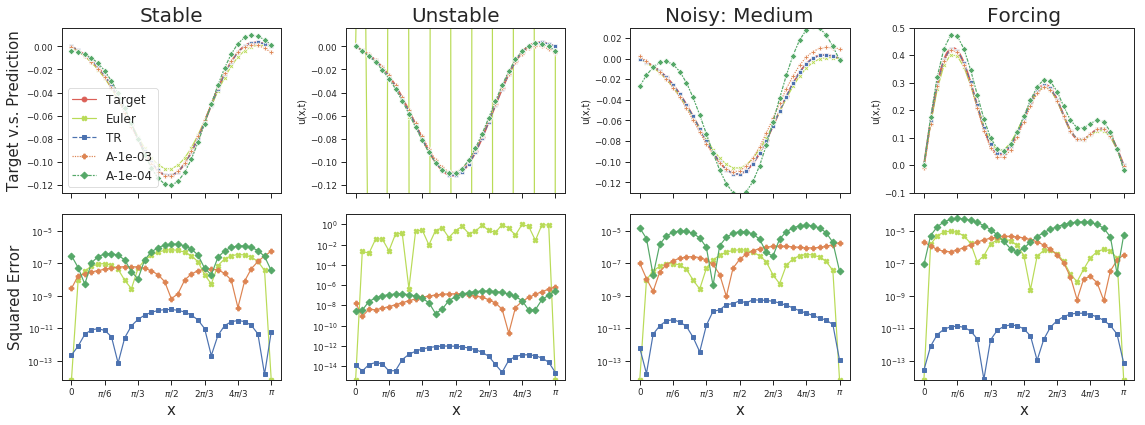

In [11]:
from scipy.interpolate import make_interp_spline, BSpline
sns.set()
sns.set(context="paper",font='serif')
sns.set_style("ticks")

colormap = sns.color_palette("hls", 5)[1:5]
int_no = 11
xold = range(0,31)
xnew = np.linspace(0,30,30*int_no)

sample = stable_real_signal[0].shape[0]

real_initial = []
real_u = []
for s in [0]:
    real_u+=[[xi,ri,'initial'] for xi,ri in \
             zip(range(31),list(stable_real_signal[0][s].squeeze(0).cpu().numpy()))]
    temp_u = []
    spl = make_interp_spline(xold, stable_real_signal[0][s].squeeze(0).cpu().numpy(), k=3) # type: BSpline
    temp_u+=[[xi,ri,'Target'] for xi,ri in zip(list(xnew),list(spl(xnew)))]
    real_initial+=temp_u
    
initial_df = pd.DataFrame(data=real_initial,columns=['x',"u(x,0)",'algo'])
real_df = pd.DataFrame(data=real_u,columns=['x',"u(x,0)",''])


fig, ax = plt.subplots(2, 4,figsize=(16,6),sharex=True,sharey=False)
palette = sns.color_palette("hls", 5)[:1]


for t in [4]:
    real_u_t=[]
    real_t=[]
    
    # first row: target vs prediction
    pred_t = []
    for s in [0]:
        real_u_t+=[[xi,ri,'initial'] for xi,ri in \
             zip(range(31),list(stable_real_signal[t+1][s].squeeze(0).cpu().numpy()))]
        temp_u = []
        spl = make_interp_spline(xold, stable_real_signal[t+1][s].squeeze(0).cpu().numpy(), k=3) # type: BSpline
        temp_u+=[[xi,ri,'Target'] for xi,ri in zip(list(xnew),list(spl(xnew)))]
        real_t+=temp_u
        
        pred_t += [[xi,ti,'Euler'] for xi,ti in zip(range(31),list(stable_EU_pred[t][s][0]))]
        pred_t += [[xi,ti,'TR'] for xi,ti in zip(range(31),list(stable_TR_pred[t][s][0]))]
        pred_t += [[xi,ti,'A-1e-03'] for xi,ti in zip(range(31),list(stable_A3_pred[t][s][0]))]
        pred_t += [[xi,ti,'A-1e-04'] for xi,ti in zip(range(31),list(stable_A4_pred[t][s][0]))]
    
    t_df = pd.DataFrame(data=real_t,columns=['x',"u(x,t)",'algo'])
    real_df = pd.DataFrame(data=real_u_t,columns=['x',"u(x,t)",''])
    
    palette = sns.color_palette("hls", 5)[:1]
    sns.lineplot(x="x", y="u(x,t)",dashes=True,lw=2.0,markers=True,markevery=int_no,palette=palette,legend='full',\
                     hue="algo",style="algo",ci=None,data=t_df,ax=ax[0][0])
    sns.lineplot(x="x", y="u(x,t)",dashes=[(0,1)],markers=True,markerfacecolor="r",legend=False,\
                     hue="",style="",ci=None,data=real_df,ax=ax[0][0])
    
    pred_t_df = pd.DataFrame(data=pred_t,columns=['x',"u(x,t)",'algo'])
    palette = sns.color_palette("hls", 5)[1:2] + sns.color_palette()[:3]
    
    
    sns.lineplot(x="x", y="u(x,t)",dashes=True,markers=['X','s','P','D'],palette=palette,legend='full',\
                     hue="algo",style="algo",ci=None,data=pred_t_df,ax=ax[0][0])
    ax[0][0].set_ylabel('Target v.s. Prediction',fontsize=15)
    ax[0][0].set_title('Stable',fontdict={'fontsize':20})
    
    handles, labels = ax[0][0].get_legend_handles_labels()
    ax[0][0].legend(handles[1:2]+handles[3:], labels[1:2]+labels[3:], loc='lower left',fontsize=12)
    ax[0][0].set_xticks(np.arange(0,31,5))
    ax[0][0].set_xticklabels(\
                (0,  '$\pi/6$','$\pi/3$','$\pi/2$', '$2\pi/3$','$4\pi/3$','$\pi$'))
    
    
        
       

    # second row: mean squared error
    target = stable_real_signal[t+1][s:s+1,0,:].cpu().numpy()
    
    trustregion = np.sum((stable_TR_pred[t][s:s+1,0,:] - target)**2,axis=0)/50.0
    adam3 = np.sum((stable_A3_pred[t][s:s+1,0,:] - target)**2,axis=0)/50.0
    adam4 = np.sum((stable_A4_pred[t][s:s+1,0,:] - target)**2,axis=0)/50.0
    eulermethod = np.sum((stable_EU_pred[t][s:s+1,0,:] - target)**2,axis=0)/50.0
    eulermethod[0]=7e-15
    eulermethod[30]=7e-15
    ax[1][0].semilogy(range(31),eulermethod,dashes='',marker="X",c=colormap[0],label='Euler')
    ax[1][0].semilogy(range(31),trustregion,dashes='',marker="s",c='C0',label='TR')
    ax[1][0].semilogy(range(31),adam3,marker='P',dashes='',c='C1',label='A-1e-03')
    ax[1][0].semilogy(range(31),adam4,marker='D',dashes='',c='C2',label='A-1e-04')
    ax[1][0].set_ylim([7e-15,1e-4])
    ax[1][0].set_xlabel('x',fontsize=15)
    ax[1][0].set_ylabel('Squared Error',fontsize=15)
    
    

    
    
colormap = sns.color_palette("hls", 5)[1:5]
int_no = 11
xold = range(0,31)
xnew = np.linspace(0,30,30*int_no)

sample = unstable_real_signal[0].shape[0]

real_initial = []
real_u = []
for s in [0]:
    real_u+=[[xi,ri,'initial'] for xi,ri in \
             zip(range(31),list(unstable_real_signal[0][s].squeeze(0).cpu().numpy()))]
    temp_u = []
    spl = make_interp_spline(xold, unstable_real_signal[0][s].squeeze(0).cpu().numpy(), k=3) # type: BSpline
    temp_u+=[[xi,ri,'Target'] for xi,ri in zip(list(xnew),list(spl(xnew)))]
    real_initial+=temp_u
    
initial_df = pd.DataFrame(data=real_initial,columns=['x',"u(x,0)",'algo'])
real_df = pd.DataFrame(data=real_u,columns=['x',"u(x,0)",''])

palette = sns.color_palette("hls", 5)[:1]


for t in [4]:
    real_u_t=[]
    real_t=[]
    
    # first row: target vs prediction
    pred_t = []
    for s in [0]:
        real_u_t+=[[xi,ri,'initial'] for xi,ri in \
             zip(range(31),list(unstable_real_signal[t+1][s].squeeze(0).cpu().numpy()))]
        temp_u = []
        spl = make_interp_spline(xold, unstable_real_signal[t+1][s].squeeze(0).cpu().numpy(), k=3) # type: BSpline
        temp_u+=[[xi,ri,'Target'] for xi,ri in zip(list(xnew),list(spl(xnew)))]
        real_t+=temp_u
        
        pred_t += [[xi,ti,'Euler'] for xi,ti in zip(range(31),list(unstable_EU_pred[t][s][0]))]
        pred_t += [[xi,ti,'TR'] for xi,ti in zip(range(31),list(unstable_TR_pred[t][s][0]))]
        pred_t += [[xi,ti,'A-1e-03'] for xi,ti in zip(range(31),list(unstable_A3_pred[t][s][0]))]
        pred_t += [[xi,ti,'A-1e-04'] for xi,ti in zip(range(31),list(unstable_A4_pred[t][s][0]))]
    
    t_df = pd.DataFrame(data=real_t,columns=['x',"u(x,t)",'algo'])
    real_df = pd.DataFrame(data=real_u_t,columns=['x',"u(x,t)",''])
    
    palette = sns.color_palette("hls", 5)[:1]
    sns.lineplot(x="x", y="u(x,t)",dashes=True,lw=2.0,markers=True,markevery=int_no,palette=palette,legend=False,\
                     hue="algo",style="algo",ci=None,data=t_df,ax=ax[0][1])
    sns.lineplot(x="x", y="u(x,t)",dashes=[(0,1)],markers=True,markerfacecolor="r",legend=False,\
                     hue="",style="",ci=None,data=real_df,ax=ax[0][1])
    
    pred_t_df = pd.DataFrame(data=pred_t,columns=['x',"u(x,t)",'algo'])
    palette = sns.color_palette("hls", 5)[1:2] + sns.color_palette()[:3]
    
    
    sns.lineplot(x="x", y="u(x,t)",dashes=True,markers=['X','s','P','D'],palette=palette,legend=False,\
                     hue="algo",style="algo",ci=None,data=pred_t_df,ax=ax[0][1])
    ax[0][1].set_ylim([-0.12676316920220482, 0.01629040637721484])    
    ax[0][1].set_title('Unstable',fontdict={'fontsize':20})
    ax[0][1].set_xticks(np.arange(0,31,5))
    ax[0][1].set_xticklabels(\
                (0,  '$\pi/6$','$\pi/3$','$\pi/2$', '$2\pi/3$','$4\pi/3$','$\pi$'))

    # second row: mean squared error
    target = unstable_real_signal[t+1][s:s+1,0,:].cpu().numpy()
    
    trustregion = np.sum((unstable_TR_pred[t][s:s+1,0,:] - target)**2,axis=0)/50.0
    adam3 = np.sum((unstable_A3_pred[t][s:s+1,0,:] - target)**2,axis=0)/50.0
    adam4 = np.sum((unstable_A4_pred[t][s:s+1,0,:] - target)**2,axis=0)/50.0
    eulermethod = np.sum((unstable_EU_pred[t][s:s+1,0,:] - target)**2,axis=0)/50.0
    eulermethod[0]=5e-16
    eulermethod[30]=5e-16
    ax[1][1].semilogy(range(31),eulermethod,dashes='',marker="X",c=colormap[0],label='Euler')
    ax[1][1].semilogy(range(31),trustregion,dashes='',marker="s",c='C0',label='TR')
    ax[1][1].semilogy(range(31),adam3,marker='P',dashes='',c='C1',label='A-1e-03')
    ax[1][1].semilogy(range(31),adam4,marker='D',dashes='',c='C2',label='A-1e-04')
    ax[1][1].set_ylim([5e-16,1e+1])
    ax[1][1].set_xlabel('x',fontsize=15)

    
colormap = sns.color_palette("hls", 5)[1:5]
int_no = 11
xold = range(0,31)
xnew = np.linspace(0,30,30*int_no)

sample = noise_real_signal[0].shape[0]

real_initial = []
real_u = []
for s in [0]:
    real_u+=[[xi,ri,'initial'] for xi,ri in \
             zip(range(31),list(noise_real_signal[0][s].squeeze(0).cpu().numpy()))]
    temp_u = []
    spl = make_interp_spline(xold, noise_real_signal[0][s].squeeze(0).cpu().numpy(), k=3) # type: BSpline
    temp_u+=[[xi,ri,'Target'] for xi,ri in zip(list(xnew),list(spl(xnew)))]
    real_initial+=temp_u
    
initial_df = pd.DataFrame(data=real_initial,columns=['x',"u(x,0)",'algo'])
real_df = pd.DataFrame(data=real_u,columns=['x',"u(x,0)",''])

palette = sns.color_palette("hls", 5)[:1]


for t in [4]:
    real_u_t=[]
    real_t=[]
    
    # first row: target vs prediction
    pred_t = []
    for s in [0]:
        real_u_t+=[[xi,ri,'initial'] for xi,ri in \
             zip(range(31),list(noise_real_signal[t+1][s].squeeze(0).cpu().numpy()))]
        temp_u = []
        spl = make_interp_spline(xold, noise_real_signal[t+1][s].squeeze(0).cpu().numpy(), k=3) # type: BSpline
        temp_u+=[[xi,ri,'Target'] for xi,ri in zip(list(xnew),list(spl(xnew)))]
        real_t+=temp_u
        
        pred_t += [[xi,ti,'Euler'] for xi,ti in zip(range(31),list(noise_EU_pred[t][s][0]))]
        pred_t += [[xi,ti,'TR'] for xi,ti in zip(range(31),list(noise_TR_pred[t][s][0]))]
        pred_t += [[xi,ti,'A-1e-03'] for xi,ti in zip(range(31),list(noise_A3_pred[t][s][0]))]
        pred_t += [[xi,ti,'A-1e-04'] for xi,ti in zip(range(31),list(noise_A4_pred[t][s][0]))]
    
    t_df = pd.DataFrame(data=real_t,columns=['x',"u(x,t)",'algo'])
    real_df = pd.DataFrame(data=real_u_t,columns=['x',"u(x,t)",''])
    
    palette = sns.color_palette("hls", 5)[:1]
    sns.lineplot(x="x", y="u(x,t)",dashes=True,lw=2.0,markers=True,markevery=int_no,palette=palette,legend=False,\
                     hue="algo",style="algo",ci=None,data=t_df,ax=ax[0][2])
    sns.lineplot(x="x", y="u(x,t)",dashes=[(0,1)],markers=True,markerfacecolor="r",legend=False,\
                     hue="",style="",ci=None,data=real_df,ax=ax[0][2])
    
    pred_t_df = pd.DataFrame(data=pred_t,columns=['x',"u(x,t)",'algo'])
    palette = sns.color_palette("hls", 5)[1:2] + sns.color_palette()[:3]
    
    
    sns.lineplot(x="x", y="u(x,t)",dashes=True,markers=['X','s','P','D'],palette=palette,legend=False,\
                     hue="algo",style="algo",ci=None,data=pred_t_df,ax=ax[0][2])
    ax[0][2].set_ylim([-0.13, 0.03])    
    ax[0][2].set_title('Noisy: Medium',fontdict={'fontsize':20})
    ax[0][2].set_xticks(np.arange(0,31,5))
    ax[0][2].set_xticklabels(\
                (0,  '$\pi/6$','$\pi/3$','$\pi/2$', '$2\pi/3$','$4\pi/3$','$\pi$'))

    # second row: mean squared error
    target = noise_real_signal[t+1][s:s+1,0,:].cpu().numpy()
    
    trustregion = np.sum((noise_TR_pred[t][s:s+1,0,:] - target)**2,axis=0)/50.0
    adam3 = np.sum((noise_A3_pred[t][s:s+1,0,:] - target)**2,axis=0)/50.0
    adam4 = np.sum((noise_A4_pred[t][s:s+1,0,:] - target)**2,axis=0)/50.0
    eulermethod = np.sum((noise_EU_pred[t][s:s+1,0,:] - target)**2,axis=0)/50.0
    eulermethod[0]=7e-15
    eulermethod[30]=7e-15
    ax[1][2].semilogy(range(31),eulermethod,dashes='',marker="X",c=colormap[0],label='Euler')
    ax[1][2].semilogy(range(31),trustregion,dashes='',marker="s",c='C0',label='TR')
    ax[1][2].semilogy(range(31),adam3,marker='P',dashes='',c='C1',label='A-1e-03')
    ax[1][2].semilogy(range(31),adam4,marker='D',dashes='',c='C2',label='A-1e-04')
    ax[1][2].set_ylim([7e-15,1e-4])
    ax[1][2].set_xlabel('x',fontsize=15)
    
    
colormap = sns.color_palette("hls", 5)[1:5]
int_no = 11
xold = range(0,31)
xnew = np.linspace(0,30,30*int_no)

sample = force_real_signal[0].shape[0]

real_initial = []
real_u = []
for s in [0]:
    real_u+=[[xi,ri,'initial'] for xi,ri in \
             zip(range(31),list(force_real_signal[0][s].squeeze(0).cpu().numpy()))]
    temp_u = []
    spl = make_interp_spline(xold, force_real_signal[0][s].squeeze(0).cpu().numpy(), k=3) # type: BSpline
    temp_u+=[[xi,ri,'Target'] for xi,ri in zip(list(xnew),list(spl(xnew)))]
    real_initial+=temp_u
    
initial_df = pd.DataFrame(data=real_initial,columns=['x',"u(x,0)",'algo'])
real_df = pd.DataFrame(data=real_u,columns=['x',"u(x,0)",''])

palette = sns.color_palette("hls", 5)[:1]


for t in [4]:
    real_u_t=[]
    real_t=[]
    
    # first row: target vs prediction
    pred_t = []
    for s in [0]:
        real_u_t+=[[xi,ri,'initial'] for xi,ri in \
             zip(range(31),list(force_real_signal[t+1][s].squeeze(0).cpu().numpy()))]
        temp_u = []
        spl = make_interp_spline(xold, force_real_signal[t+1][s].squeeze(0).cpu().numpy(), k=3) # type: BSpline
        temp_u+=[[xi,ri,'Target'] for xi,ri in zip(list(xnew),list(spl(xnew)))]
        real_t+=temp_u
        
        pred_t += [[xi,ti,'Euler'] for xi,ti in zip(range(31),list(force_EU_pred[t][s][0]))]
        pred_t += [[xi,ti,'TR'] for xi,ti in zip(range(31),list(force_TR_pred[t][s][0]))]
        pred_t += [[xi,ti,'A-1e-03'] for xi,ti in zip(range(31),list(force_A3_pred[t][s][0]))]
        pred_t += [[xi,ti,'A-1e-04'] for xi,ti in zip(range(31),list(force_A4_pred[t][s][0]))]
    
    t_df = pd.DataFrame(data=real_t,columns=['x',"u(x,t)",'algo'])
    real_df = pd.DataFrame(data=real_u_t,columns=['x',"u(x,t)",''])
    
    palette = sns.color_palette("hls", 5)[:1]
    sns.lineplot(x="x", y="u(x,t)",dashes=True,lw=2.0,markers=True,markevery=int_no,palette=palette,legend=False,\
                     hue="algo",style="algo",ci=None,data=t_df,ax=ax[0][3])
    sns.lineplot(x="x", y="u(x,t)",dashes=[(0,1)],markers=True,markerfacecolor="r",legend=False,\
                     hue="",style="",ci=None,data=real_df,ax=ax[0][3])
    
    pred_t_df = pd.DataFrame(data=pred_t,columns=['x',"u(x,t)",'algo'])
    palette = sns.color_palette("hls", 5)[1:2] + sns.color_palette()[:3]
    
    
    sns.lineplot(x="x", y="u(x,t)",dashes=True,markers=['X','s','P','D'],palette=palette,legend=False,\
                     hue="algo",style="algo",ci=None,data=pred_t_df,ax=ax[0][3])
    ax[0][3].set_ylim([-0.1,0.5])    
    ax[0][3].set_title('Forcing',fontdict={'fontsize':20})
    ax[0][3].set_xticks(np.arange(0,31,5))
    ax[0][3].set_xticklabels(\
                (0,  '$\pi/6$','$\pi/3$','$\pi/2$', '$2\pi/3$','$4\pi/3$','$\pi$'))

    # second row: mean squared error
    target = force_real_signal[t+1][s:s+1,0,:].cpu().numpy()
    
    trustregion = np.sum((force_TR_pred[t][s:s+1,0,:] - target)**2,axis=0)/50.0
    adam3 = np.sum((force_A3_pred[t][s:s+1,0,:] - target)**2,axis=0)/50.0
    adam4 = np.sum((force_A4_pred[t][s:s+1,0,:] - target)**2,axis=0)/50.0
    eulermethod = np.sum((force_EU_pred[t][s:s+1,0,:] - target)**2,axis=0)/50.0
    eulermethod[0]=7e-15
    eulermethod[30]=7e-15
    ax[1][3].semilogy(range(31),eulermethod,dashes='',marker="X",c=colormap[0],label='Euler')
    ax[1][3].semilogy(range(31),trustregion,dashes='',marker="s",c='C0',label='TR')
    ax[1][3].semilogy(range(31),adam3,marker='P',dashes='',c='C1',label='A-1e-03')
    ax[1][3].semilogy(range(31),adam4,marker='D',dashes='',c='C2',label='A-1e-04')
    ax[1][3].set_ylim([7e-15,1e-4])
    ax[1][3].set_xlabel('x',fontsize=15)

    
fig.tight_layout()
plt.show()

In [12]:
exit(0)